In [1]:
import sys
sys.path.insert(0, "./src/")

# 00-Sanity-checks

Run sanity checks for attacks and data modification.

In [13]:
import tqdm
import os

import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

from src.utils.data_utils import get_cifar10_data
from src.utils.adversary_utils import adv_attack
from src.utils.vis_utils import vis_pred

In [3]:
data = get_cifar10_data(1, img_size=32, subsample=True)

100%|██████████| 170498071/170498071 [09:53<00:00, 287130.67it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
classes = data["classes"]
_, test_loader = data["test"]

In [6]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, len(classes))
model.load_state_dict(torch.load(os.path.join(r"ckpts\standard_d_v7\best.pt")))
model.to("cuda");
model.eval();

## 1. Closer look at attack

True label:  dog
Prediction after adv attack 1:  frog


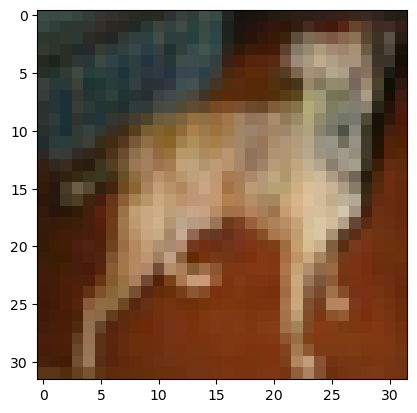

In [17]:
for batch in test_loader:
    res = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=10, alpha=0.1)
    true_y = batch[1]
    adv = model(res[0].to("cuda")).argmax(1)
    img_whc = res[0].squeeze().numpy().transpose(1,2,0)
    plt.imshow(img_whc)
    print("True label: ", classes[true_y])
    print("Prediction after adv attack 1: ", classes[adv])
    break

True label:  dog
Prediction after adv attack 1:  cat


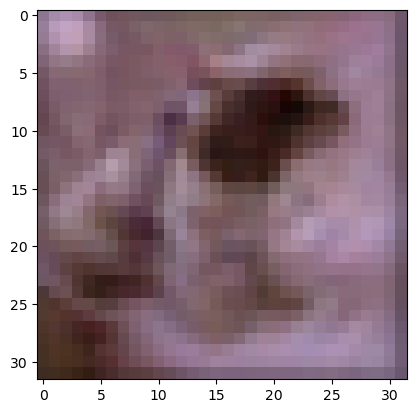

In [19]:
for batch in test_loader:
    res = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=1, steps=20, alpha=0.1)
    true_y = batch[1]
    adv = model(res[0].to("cuda")).argmax(1)
    img_whc = res[0].squeeze().numpy().transpose(1,2,0)
    plt.imshow(img_whc)
    print("True label: ", classes[true_y])
    print("Prediction after adv attack 1: ", classes[adv])
    break

## 2. Compare prediction of model before and after attack

In [20]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=7, alpha=0.1)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [06:41<00:00,  6.22it/s]


tensor([[ 374., 1675.],
        [   0.,  451.]])


## 3. Make sure pertubations only are in epsilon norm range

In [21]:
for eps in tqdm.tqdm([0.5, 1, 5]):
    for batch in tqdm.tqdm(test_loader):
        x = batch[0]
        adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=eps, steps=7, alpha=0.1)
        assert((x-adv_batch[0]).norm(p=2) <= eps + 1e-6)
print("All modifications are within maximum allowed norm.")

100%|██████████| 3/3 [18:00<00:00, 360.13s/it]

All modifications are within maximum allowed norm.
